# Markov Decision Process (mdp) in a Gridworld Environment 
## Reinforcement Learning 
### Problem
- 7x7 gridworld as an MDP:
- Given a state and an action, you should be able to execute the action and return a new state and reward.
- The actions are the cardinal directions and are deterministic. The states are just the cell the agent is currently in. Assume the third row from the top is all obstacles, except the right-most cell. The initial state is the bottom left, and the goal the top left.
- There is no discounting. The reward for reaching the goal is 20, and -1 for each action.

In [1]:
%matplotlib inline

## Environment

In [2]:
import numpy as np
class Environment:
    def __init__(self,height,width,start,goal):
        self.width = width
        self.height = height
        
        # R - possible reward space
        self.R = np.zeros((height,width)) -1
        # Obstacles
        self.R[2,:-1] = np.nan
        # Goal
        self.goal = goal
        self.R[self.goal] = 20
        
        # S - possible state states
        self.S = []       
        for index, reward in np.ndenumerate(self.R):
            # Not an obstacle
            if(not np.isnan(reward)):
                self.S.append(index)
        self.S = np.asarray(self.S)

        # A - Actions Space
        self.A = ['u','d','l','r']
        
        # s - Ini State - list for easier indexing
        self.s = list(start)
        
        # r - cumulative Reward
        self.G_t = 0
        
        self.is_done = False
        
        # Value function
        self.v = np.empty((self.height,self.width))
        self.v[:,:] = np.nan
        
    def get_rewards(self):
        return self.G_t
    
    def get_possible_rewards(self):
        return self.R
    
    def get_possible_states(self):
        return self.S
    
    def get_state(self):
        return self.s
    
    def get_actions(self):
        return self.A
    
    def get_grid_world(self):
        grid_world = np.chararray((self.width, self.height),unicode=True)
        grid_world[:] = '-'
        grid_world[self.s[0],self.s[1]]= 'a'
        grid_world[2,:-1] = 'o'
        grid_world[self.goal] = 'g'
        return grid_world
     
    def step(self, action,print_info):
        new_s,new_r = self.take_step(self.s,action)
        self.s = new_s
        if(print_info):
            print(f'old_s:{self.s} new_s:{new_s} r_t:{new_r} G_t:{self.G_t}')
            print(f"World \n {self.get_grid_world()}")
        
        self.is_done = (self.s[0] == self.goal[0] and self.s[1] == self.goal[1])
            
        return new_r,new_s,self.is_done
        
    def check_if_s_in_S(self,s):
        for possible_s in self.S:
            if(possible_s[0] == s[0] and possible_s[1] == s[1]):
                return True
        return False
    
    def is_out_of_bounds(self,new_s):
        if((new_s[0] < 0 or new_s[0]>self.height-1) or (new_s[1] < 0 or new_s[1]>self.width-1)):
            return True
        return False
    
    def take_step(self,s,a):
        if(a not in self.A):
            raise ValueError('Unknown action', a)
        new_s = s.copy()
        if(a == 'u'):
            new_s[0] -= 1
        if(a == 'd'):
            new_s[0] += 1
        if(a == 'l'):
            new_s[1] -= 1
        if(a == 'r'):
            new_s[1] += 1
         
        # Out of bounds - stay in same place
        if(self.is_out_of_bounds(new_s)):
            return s,-1
        # Check Obstacles - not in possible states - stay in same place
        elif(not self.check_if_s_in_S(new_s)):
            return s,-1
        return new_s,self.R[new_s[0],new_s[1]]
    
    def get_v(self,immediate_r,future_r):
        return immediate_r + future_r
    
    def update_coords_value(self,point,successor):
        if(not self.is_out_of_bounds(point)):
            self.v[point] = self.get_v(self.R[point],self.R[successor])
            return point
        return None
    
    
    def get_r(self,prev_s,new_s):
        if(not self.is_out_of_bounds(new_s)):
            if(np.isnan(self.prev_v[new_s[0],new_s[1]])):
                return None
            if(not np.isnan(self.prev_v[new_s[0],new_s[1]])):
                new_r= self.prev_v[new_s[0],new_s[1]]
            else:
                new_r =  self.R[new_s[0],new_s[1]]
            
            if(np.isnan(self.prev_v[prev_s[0],prev_s[1]])):
                return new_r
            if(new_r > self.prev_v[prev_s[0],prev_s[1]]):
                return_r= new_r
            else:
                return_r= self.prev_v[prev_s[0],prev_s[1]]
            return return_r
                
        return None
    
    def max_r_best_a(self,s):
        if(not np.isnan(self.prev_v[s[0],s[1]])):
            return None
        
        above_p = (s[0]-1,s[1])
        below_p = (s[0]+1,s[1])
        left_p  = (s[0],s[1]-1)
        right_p = (s[0],s[1]+1)
        
        above_p_r= self.get_r(s,above_p)
        below_p_r = self.get_r(s,below_p)
        left_p_r = self.get_r(s,left_p)
        right_p_r = self.get_r(s,right_p)
         
        best_r = -1000
        if(above_p_r is not None and  (above_p_r>best_r)):
            best_r = above_p_r
        if(below_p_r is not None and  (below_p_r>best_r)):
            best_r = below_p_r
        if(left_p_r is not None and (left_p_r>best_r)):
            best_r = left_p_r
        if(right_p_r is not None and (right_p_r>best_r)):
            best_r = right_p_r
        if(best_r == -1000):
            return np.nan
        
        return best_r
    
    def is_obstacle(self,s):
        if(np.isnan(self.R[s[0],s[1]])):
            return True
        
    def get_value_iterative(self,point):
        if(point is None or self.is_out_of_bounds(point)):
            return
        eps = 1e-20
        max_iterations = 100
        self.v[point] = self.get_v(self.R[point[0],point[1]],0)
        for i in range(max_iterations):
            self.prev_v = np.copy(self.v)
            for s in self.S:
                max_r = self.max_r_best_a(s)
                if(max_r is not None):
                    self.v[s[0],s[1]] = self.get_v(self.R[s[0],s[1]],max_r)
                    
            if (np.sum(np.fabs(self.prev_v - self.v)) <= eps):
                print ('Value-iteration converged at iteration# %d.' %(i+1))
                break
        
        return self.v
    
    def get_value_function(self):
        return self.get_value_iterative(self.goal)

In [3]:
height=7
width=7

env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
print(f"World \n {env.get_grid_world()}")

World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['a' '-' '-' '-' '-' '-' '-']]


## Agents

In [4]:
import random
class RandomAgent():
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)
        
        self.r_t = np.array([])
        # r - cumulative Reward
        self.G_t = 0
    
    def step(self,s=None):
        return self.actions[random.randint(0, self.num_actions-1)]
    
    def update(self,new_s,reward):
        self.s = new_s
        self.r_t = np.append(self.r_t,reward)
        self.G_t += reward
        return self.r_t,self.G_t
    
class GreedyAgent():
    def __init__(self, actions,value_func,height=7,width=7):
        self.height = height
        self.width = width
        
        self.actions = actions
        self.num_actions = len(actions)
        self.value_func = value_func
        
        self.r_t = np.array([])
        # r - cumulative Reward
        self.G_t = 0
    
    def is_out_of_bounds(self,new_s):
        if((new_s[0] < 0 or new_s[0]>self.height-1) or (new_s[1] < 0 or new_s[1]>self.width-1)):
            return True
        return False
    
    def get_value(self,possible_s):
        if(not self.is_out_of_bounds(possible_s)):
            return self.value_func[possible_s[0],possible_s[1]]
        return None
    
    def step(self,s):
        above_p = (s[0]-1,s[1])
        below_p = (s[0]+1,s[1])
        left_p  = (s[0],s[1]-1)
        right_p = (s[0],s[1]+1)
        
        above_p_v= self.get_value(above_p)
        below_p_v = self.get_value(below_p)
        left_p_v = self.get_value(left_p)
        right_p_v = self.get_value(right_p)
        
#         self.A = ['u','d','l','r']
        best_a = [False] *4
    
        best_v = -1000
        if(above_p_v is not None and  (above_p_v>best_v)):
            best_v = above_p_v
            best_a[0] = True
        if(below_p_v is not None and  (below_p_v>best_v)):
            best_v = below_p_v
            best_a = [False] *4
            best_a[1] = True
        if(left_p_v is not None and (left_p_v>best_v)):
            best_v = left_p_v
            best_a = [False] *4
            best_a[2] = True
        if(right_p_v is not None and (right_p_v>best_v)):
            best_v = right_p_v
            best_a = [False] *4
            best_a[3] = True
    
        return self.actions[np.where(best_a)[0][0]]

    def update(self,new_s,reward):
        self.s = new_s
        self.r_t = np.append(self.r_t,reward)
        self.G_t += reward
        return self.r_t,self.G_t

## Experiment class

In [5]:
class Experiment():
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        
    def run(self, num_steps,print_info=False):
        steps = 0
        done = False
        reward = .0
        rewards = np.array([])
        losses = []

        while steps < num_steps:       
            action = self.agent.step(env.get_state())
            reward,new_s,is_done = self.env.step(action,print_info=print_info)
            r_t, cumulative_r = self.agent.update(new_s,reward)
            if(print_info):
                print(f"*** Step: {steps} ***")
                print(f"Cumulative_r:{cumulative_r}")
            steps += 1
            
            if(is_done):
                if(print_info):
                    print(f"At Goal:{new_s}")
                break
            
        return cumulative_r

## Average Performance Over 20 runs
1. Run a random agent on this domain that terminates after 50 steps.
2. Use value iteration to compute an optimal MDP policy. Then have a greedy agent follow this policy. 

In [6]:
height=7
width=7

env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
print(f"Value Function \n {env.get_value_function()}")

Value Function 
 [[20. 19. 18. 17. 16. 15. 14.]
 [19. 18. 17. 16. 15. 14. 13.]
 [nan nan nan nan nan nan 12.]
 [ 5.  6.  7.  8.  9. 10. 11.]
 [ 4.  5.  6.  7.  8.  9. 10.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 2.  3.  4.  5.  6.  7.  8.]]


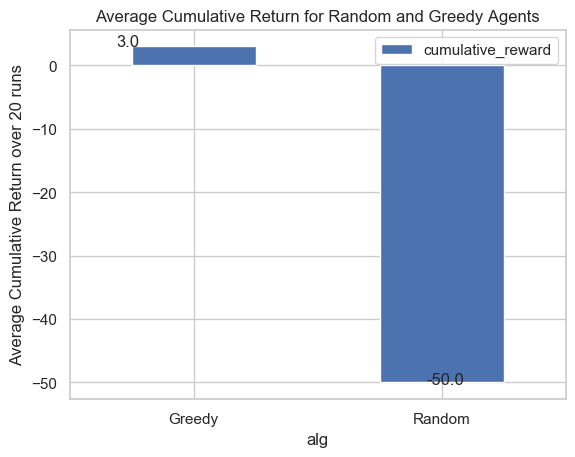

In [7]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import  pandas as pd

greedy_agent_cum_r = []
random_agent_cum_r = []
eight=7
width=7


sns.set(style="whitegrid")

for i in range(20):
    env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
    random_agent = RandomAgent(env.get_actions())
    exp = Experiment(agent=random_agent,env=env)
    random_agent_cum_r.append(exp.run(50,False))
    
for i in range(20):
    env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
    greedy_agent = GreedyAgent(env.get_actions(),env.get_value_function())
    exp = Experiment(agent=greedy_agent,env=env)
    greedy_agent_cum_r.append(exp.run(50,False))

def mean(lst): 
    return sum(lst) / len(lst) 

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        break
        
    
greedy_agent_mean_r = mean(greedy_agent_cum_r)
random_agent_mean_r = mean(random_agent_cum_r)

df = pd.DataFrame({'alg':['Greedy', 'Random'], 'cumulative_reward':[greedy_agent_mean_r, random_agent_mean_r]})
ax = df.plot.bar(x='alg', y='cumulative_reward', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.250, p.get_height() * 1.005))
    
plt.ylabel('Average Cumulative Return over 20 runs')
plt.title('Average Cumulative Return for Random and Greedy Agents')


plt.show()



## Sample Trajectory

### Random Agent

In [8]:
height=7
width=7

env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
random_agent = RandomAgent(env.get_actions())
exp = Experiment(agent=random_agent,env=env)
exp.run(50,print_info=True)

old_s:[5, 0] new_s:[5, 0] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['a' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 0 ***
Cumulative_r:-1.0
old_s:[5, 0] new_s:[5, 0] r_t:-1 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['a' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 1 ***
Cumulative_r:-2.0
old_s:[5, 1] new_s:[5, 1] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' 'a' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 2 ***
Cumulative_r:-3.0
old_s:[4, 1] new_s:[4, 1] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '

-50.0

### Greedy Agent

In [9]:
height=7
width=7

env = Environment(height=7,width=7,start=(height-1,0),goal=(0,0))
random_agent = GreedyAgent(env.get_actions(),env.get_value_function())
exp = Experiment(agent=random_agent,env=env)
exp.run(50,True)

old_s:[5, 0] new_s:[5, 0] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['a' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 0 ***
Cumulative_r:-1.0
old_s:[4, 0] new_s:[4, 0] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['a' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 1 ***
Cumulative_r:-2.0
old_s:[3, 0] new_s:[3, 0] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' '-']
 ['a' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-']]
*** Step: 2 ***
Cumulative_r:-3.0
old_s:[3, 1] new_s:[3, 1] r_t:-1.0 G_t:0
World 
 [['g' '-' '-' '-' '-' '-' '-']
 ['-' '-' '-' '-'

3.0